# PCA & MFCC

In [25]:
pathAudioHalf = 'D:/AudioIRA/dataset7.new.0.5/'

pathAudioOne = 'D:/AudioIRA/dataset7.new.1/'

pathAudioThree = 'D:/AudioIRA/dataset7.new.3/'

pathAudioFive = 'D:/python/AI project/sound recognistion/data/five_seconds/'


# Basic Libraries

In [48]:
from sklearn.decomposition import PCA
from collections import Counter
import scipy
from sklearn.neural_network import MLPClassifier
import pandas as pd

from sklearn.model_selection import KFold
import IPython.display as ipd
from pywt import wavedec
import pywt
import copy
from scipy.io import wavfile

import random
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
import wave
import librosa
import numpy as np
import sklearn
import librosa.display
import matplotlib.pyplot as plt
import sklearn
import warnings
from glob import glob
from librosa import feature
import csv
import pandas as pd
import os
warnings.filterwarnings('ignore')


pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Functions For Audio

In [27]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
          return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1, :])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:, :])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))


    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    @staticmethod
    def apply_LowPassFilter(aud):
        transform = Compose(
            [LowPassFilter(sample_rate=aud[1])],
        )
        t_audio = transform(aud[0])
        # torchaudio.save("tests/filter.wav", t_audio, sample_rate=sample_rate)
        assert t_audio.shape == aud[0].shape

        return t_audio , aud[1]
    @staticmethod
    def lowpassfilter(signal, thresh = 0.63, wavelet="db2",level=4):
        thresh = thresh*np.nanmax(signal)
        coeff = pywt.wavedec(signal, wavelet, mode="per" ,level=level)
        coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
        reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
        return reconstructed_signal




# Basic Function

In [28]:
def readDataFirst(num,level=2,thresh=1,augmentData=False , dwt = False , dwtMfcc = False , mfcc = False):
    if(num == 0.5):
        data_dir = pathAudioHalf
        folders = glob(data_dir+'/*')

        feat = []
        lab = []
    if(num == 1):
        data_dir = pathAudioOne
        folders = glob(data_dir+'/*')

        feat = []
        lab = []
    if(num == 3):
        data_dir = pathAudioThree
        folders = glob(data_dir+'/*')

        feat = []
        lab = []
    if(num == 5):
        data_dir = pathAudioFive
        folders = glob(data_dir+'/*')

        feat = []
        lab = []
        
        
    i=-1
    for folder in folders:
        audio_files=glob(folder + '/*.wav')
        i=i+1
        for file in audio_files:
            
            
            if dwtMfcc:
                sr,signal=wavfile.read(file)
                if len(signal.shape) == 2:
                    signal = signal.T
                    signal = signal[0]
                aud2 = AudioUtil.lowpassfilter(signal,thresh = thresh,level = level)        
                aud2 = aud2/max(aud2)
                aud2=aud2.reshape(1,aud2.shape[0])
                tens=torch.tensor(aud2,dtype=torch.float32)
                aud=(tens,sr)

                reaud = AudioUtil.resample(aud, 16000)
                rechan = AudioUtil.rechannel(reaud, 2)
                sgram = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None).T
                s = np.mean(np.array(sgram),axis=0)
                s.reshape(128)
                feat.append(s)
                lab.append(i)
                
                
                
            if dwt:
                aud = AudioUtil.open(file)
                reaud = AudioUtil.resample(aud, 16000)
                rechan = AudioUtil.rechannel(reaud, 2)
                sgram = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None).T
                s = np.mean(np.array(sgram),axis=0)
                s = s.reshape(128)
                feat.append(np.array(s))
                lab.append(i)
             
            if mfcc : 
                aud = AudioUtil.open(file)
                reaud = AudioUtil.resample(aud, 16000)
                rechan = AudioUtil.rechannel(reaud, 2)
                sgram = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None).T
                s = np.mean(np.array(sgram),axis=0)
                s = s.reshape(128)
                feat.append(s)
                lab.append(i)
            

            
            
            if augmentData:
                sgram2 = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None)
                aug_sgram = AudioUtil.spectro_augment(sgram2, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2).T
                s2 = np.mean(np.array(aug_sgram),axis=0)
                s2 = s2.reshape(128)
                feat.append(s2)
                lab.append(i)
            
                
            
    
    return [feat , lab]




# Model

In [29]:
def intiModel(X_train , X_test , Y_train , Y_test , PCA = False,DWT=False):
    
    if PCA :         
        X_train = X_train.reshape(X_train.shape[0], 4, 8, 1)
        X_test = X_test.reshape(X_test.shape[0], 4, 8, 1)

        input_dim = (4, 8, 1)
    elif DWT:
        X_train=X_train.reshape(X_train.shape[0],10,5,1)
        X_test=X_test.reshape(X_test.shape[0],10,5,1)
        input_dim=(10,5,1)
    else : 
        X_train = X_train.reshape(X_train.shape[0], 16, 8, 1)
        X_test = X_test.reshape(X_test.shape[0], 16, 8, 1)

        input_dim = (16, 8, 1)

    model = Sequential()

    model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), padding = "same", activation = "tanh"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(1024, activation = "tanh"))
    model.add(Dense(Y_train.shape[1], activation = "softmax"))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model , X_train , X_test ,Y_train , Y_test

In [30]:
def cumulative_explained_variance(X):
    pca = PCA().fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

In [31]:
def get_pca_projection(n_compnent,X):
    pca = PCA(n_compnent)  # project from 64 to n_compnent dimensions
    projected = pca.fit_transform(X)
    print ('original data shape : ')
    print(X.shape)
    print ('projected data shape : ')
    print(projected.shape)
    return projected

# Draw Functions

## draw History

In [32]:
def drawHistory(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## draw all historys

### model accuracy

In [33]:
def drawALLHistoryAccuracy(history):
    for i in range(5):
        plt.plot(history[i].history['accuracy'])
    plt.title('train model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['KFold1', 'KFold2','KFold3','KFold4','KFold5'], loc='upper left')
    plt.show()
    
    for i in range(5):
        plt.plot(history[i].history['val_accuracy'])
    plt.title('test model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['KFold1', 'KFold2','KFold3','KFold4','KFold5'], loc='upper left')
    plt.show()

### model loss

In [34]:
def drawALLHistoryLoss(history):
    for i in range(5):
        plt.plot(history[i].history['loss'])
    plt.title('train model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['KFold1', 'KFold2','KFold3','KFold4','KFold5'], loc='upper left')
    plt.show()
    
    for i in range(5):
        plt.plot(history[i].history['val_loss'])
    plt.title('test model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['KFold1', 'KFold2','KFold3','KFold4','KFold5'], loc='upper left')
    plt.show()

## draw Confusion Matrix

In [35]:
def drawConfusionMatrix(Y_test,preds):
    confusion_mc = confusion_matrix(Y_test, preds)
    # put it in data frame to visualize
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,confusion_mc.shape[0])], columns = [i for i in range(0,confusion_mc.shape[0])])
    plt.figure(figsize=(20,20))
    sns.heatmap(df_cm, annot=True,)
    plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(Y_test,preds)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Initializing the variables model

In [36]:
def intialVariabels(num, augmentData=False ,dwt = False,mfcc=False,dwtMfcc=False):    
    
    #read and init data to half second model
    temp = readDataFirst(num = num , level=1 , thresh=0.01 , augmentData = augmentData ,dwt = dwt,dwtMfcc=dwtMfcc,mfcc=mfcc)
    temp = np.array(temp)
    data = temp.transpose()
    X_ = data[:, 0]
    Y = data[:, 1]

    X = np.empty([X_.shape[0], 128])
    for i in range(X_.shape[0]):
        X_[i] = np.reshape(X_[i] , (128))
        X[i] = (X_[i]) 

    Y = to_categorical(Y)
    if dwt:
        X, Y = get_ecg_features(X, Y, 'db4')

    print('All Data leangth is : {}'.format(X_.shape[0]))
    print()
    print('categorical leangth is : {}'.format(Y.shape[0]))
    
    return X , Y 




# Kfold Fiting Model Cnn

In [53]:
def fitingModelCnn(X , Y , PCA = False,DWT=False):
    #scores & history & confusionMatrix & BPNN data X,Y & historyBPNN
    scores = []
    history = []
    confusionMatrix = []
    BPNN = []
    
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    iKFold = 1 
    for train_index, test_index in cv.split(X):
        #split data to train & test  from KFOLD Split
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
        print('Train Data leangth for KFold :{} : is {}'.format(iKFold , X_train.shape[0]))
        print('Test Data leangth for KFold :{} : is {}'.format(iKFold , X_test.shape[0]))
        print()
        print()

        #intializing cnn model to half second model
        halfSecondModel, halfSecondX_train , halfSecondX_test ,halfSecondY_train ,halfSecondY_test = intiModel(X_train , X_test , y_train , y_test , PCA = PCA,DWT=DWT)

        #fit model
        historyT = halfSecondModel.fit(halfSecondX_train, halfSecondY_train, epochs = 7, batch_size = 50, validation_data = (halfSecondX_test, halfSecondY_test))

        #evaluate model
        ModelScore = halfSecondModel.evaluate(halfSecondX_test, halfSecondY_test)

        #save result
        scores.append(ModelScore[1])
        history.append(historyT)

        #save for confusionMatrix
        predictions = halfSecondModel.predict(halfSecondX_test)
        predictions = np.argmax(predictions, axis = 1)
        Y_test_max = np.argmax(halfSecondY_test, axis = 1)
        confusionMatrix.append([Y_test_max,predictions])    

        #save for BPNN
        BPNN.append([halfSecondX_train, halfSecondX_test, halfSecondY_train, halfSecondY_test])


        iKFold = iKFold +1
        
    return scores, history , confusionMatrix , BPNN



# DWT Functions

In [38]:
def showSignal(file):
    sr,signal=wavfile.read(file);
    (cA1, cD1) = pywt.dwt(signal, 'db2', 'smooth')
    reconstructed_signal = pywt.idwt(cA1, cD1, 'db2', 'smooth')
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(signal, label='signal')
    ax.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
    ax.legend(loc='upper left')
    plt.show()
    
    return signal , sr

In [39]:
def get_ecg_features(ecg_data, ecg_labels, waveletname):
    list_features = []
    #list_unique_labels = list(set(ecg_labels))
    
#     list_labels = [list_unique_labels.index(elem) for elem in ecg_labels]
    list_labels = ecg_labels
    
    #list_labels = ecg_labels
    for signal in ecg_data:
        list_coeff = pywt.wavedec(signal, waveletname)
        features = []
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
    return list_features, list_labels



In [40]:
def showMultiLevel(chirp_signal):
    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Chirp Signal: ")
    ax.plot(chirp_signal)
    plt.show()

    data = chirp_signal
    waveletname = 'sym5'

    fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
    for ii in range(5):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')
        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        axarr[ii, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

In [41]:
def showDWT(signal):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(signal, color="b", alpha=0.5, label='original signal')
    rec = AudioUtil.lowpassfilter(signal, thresh=0.01,level=2)
    ax.plot(rec, 'k', label='DWT smoothing}', linewidth=1)
    ax.legend()
    ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
    ax.set_ylabel('Signal Amplitude', fontsize=16)
    ax.set_xlabel('Sample No', fontsize=16)
    plt.show()
    ipd.Audio(rec, rate=sr)

In [42]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) , 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    if np.nanmean(list_values)>0:
        mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) , int(np.nanmean(list_values))))[0]
    else:
        mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) , 0))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy]  + statistics

# save accuracy

In [43]:
def saveAccuracy(scores , all_history , file , isCNN ):
    iKFold = 0
    score = 0
    indexMaxScore = 0
    for sc in scores:
        if sc > score:
            score = sc
            indexMaxScore = iKFold
        iKFold = iKFold +1
    bestScore_halfSecond = all_history[indexMaxScore]
    

    # convert the history.history dict to a pandas DataFrame:
    if isCNN :
        hist_df = pd.DataFrame(bestScore_halfSecond.history)
    else : 
        hist_df = pd.DataFrame(bestScore_halfSecond.validation_scores_) 
    #save to csv: 
    #hist_csv_file = file
    #with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(file,index=False)

# show all accuracy levels

## CNN accuracy levels

In [44]:
def ALLCNNAccuracyLevels(histLevel1 , histLevel2 ,title1 , title2 ,nLevel1 , nLevel2):
    plt.plot(histLevel1['accuracy'])      
    plt.plot(histLevel2['accuracy'])

    plt.title(title1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend([nLevel1 , nLevel2 ], loc='upper left')
    plt.show()
    
    plt.plot(histLevel1['val_accuracy'])      
    plt.plot(histLevel2['val_accuracy'])
    
    plt.title(title2)
    plt.ylabel('val_accuracy')
    plt.xlabel('epoch')
    plt.legend([nLevel1 , nLevel2], loc='upper left')
    plt.show()

# 1- DWT

In [49]:
# if we need augment just change augmentData=True

X_dwt , Y_dwt = intialVariabels(5 , augmentData=False ,dwt = True)

All Data leangth is : 2054

categorical leangth is : 2054


In [57]:
X_dwt2=np.array(X_dwt)

In [58]:
scores_dwt, history_dwt , confusionMatrix_dwt , BPNN_dwt = fitingModelCnn(X_dwt2 , Y_dwt,DWT=True)

Train Data leangth for KFold :1 : is 1643
Test Data leangth for KFold :1 : is 411


Epoch 1/7
33/33 [==============================] - ETA: 13s - loss: 4.5732 - accuracy: 0.0000e+0 - ETA: 2s - loss: 4.8880 - accuracy: 0.0000e+0 - ETA: 2s - loss: 4.9336 - accuracy: 0.0000e+ - ETA: 2s - loss: 4.9317 - accuracy: 0.0050   - ETA: 1s - loss: 4.9110 - accuracy: 0.00 - ETA: 1s - loss: 4.8489 - accuracy: 0.00 - ETA: 1s - loss: 4.8071 - accuracy: 0.00 - ETA: 1s - loss: 4.7504 - accuracy: 0.00 - ETA: 1s - loss: 4.7448 - accuracy: 0.00 - ETA: 1s - loss: 4.7320 - accuracy: 0.01 - ETA: 1s - loss: 4.7491 - accuracy: 0.00 - ETA: 1s - loss: 4.7216 - accuracy: 0.01 - ETA: 1s - loss: 4.7035 - accuracy: 0.01 - ETA: 1s - loss: 4.6962 - accuracy: 0.01 - ETA: 1s - loss: 4.6904 - accuracy: 0.01 - ETA: 1s - loss: 4.6817 - accuracy: 0.01 - ETA: 1s - loss: 4.6746 - accuracy: 0.01 - ETA: 1s - loss: 4.6760 - accuracy: 0.01 - ETA: 1s - loss: 4.6556 - accuracy: 0.01 - ETA: 0s - loss: 4.6433 - accuracy: 0.01 - ETA: 0

### evaluate model

In [59]:
iKFold =1
for ev in scores_dwt:
    print("this is score for :{} KFold:".format(iKFold))
    print(ev)
    print()
    iKFold+=1

this is score for :1 KFold:
0.5742092728614807

this is score for :2 KFold:
0.540145993232727

this is score for :3 KFold:
0.5669099688529968

this is score for :4 KFold:
0.5596107244491577

this is score for :5 KFold:
0.5609756112098694



### draw all history one by one

this is history for :1 KFold:


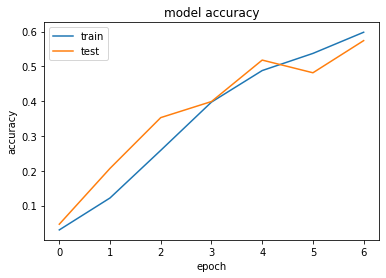

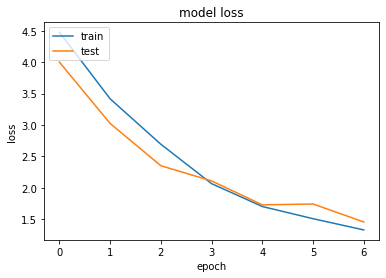


this is history for :2 KFold:


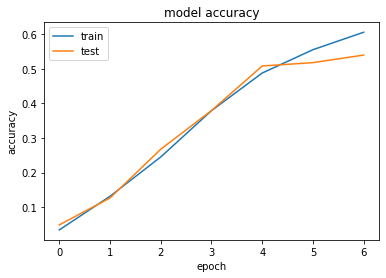

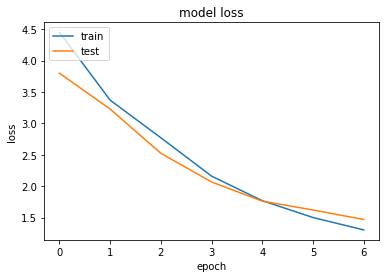


this is history for :3 KFold:


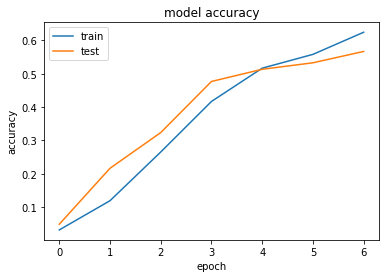

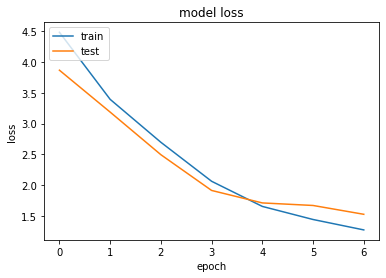


this is history for :4 KFold:


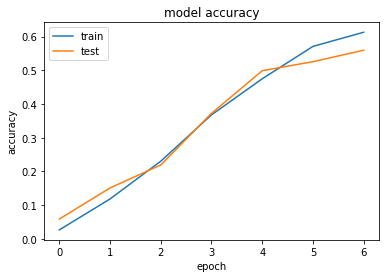

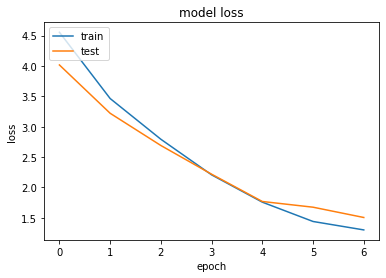


this is history for :5 KFold:


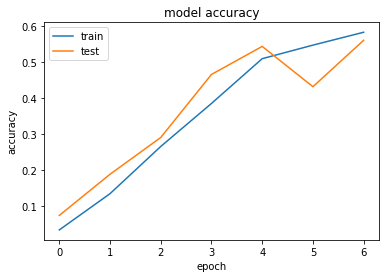

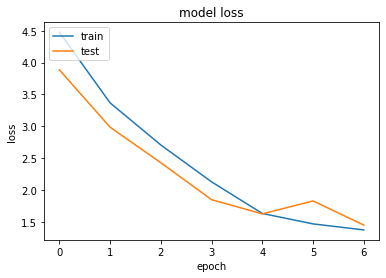

In [60]:
iKFold =1
for hist in history_dwt:
    print("this is history for :{} KFold:".format(iKFold))
    drawHistory(hist)
    print()
    iKFold =iKFold + 1

### draw all history accuracy

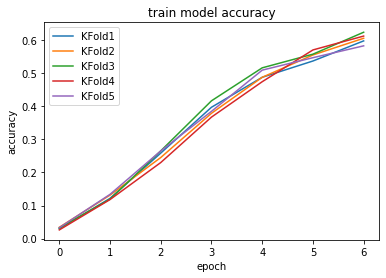

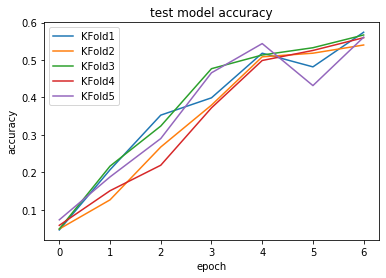

In [61]:
drawALLHistoryAccuracy(history_dwt)

### draw all history loss

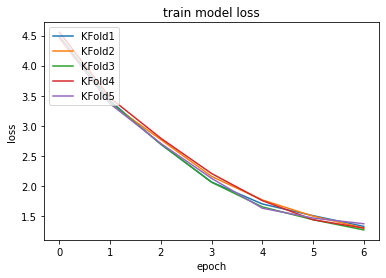

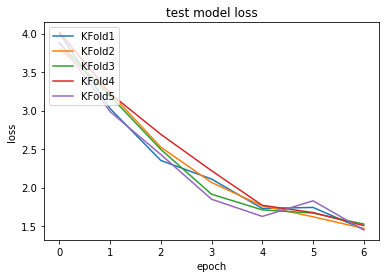

In [62]:
drawALLHistoryLoss(history_dwt)

### draw confusion matrix 

this is confusion Matrix for :1 KFold:

this is confusion Matrix for :2 KFold:

this is confusion Matrix for :3 KFold:

this is confusion Matrix for :4 KFold:

this is confusion Matrix for :5 KFold:



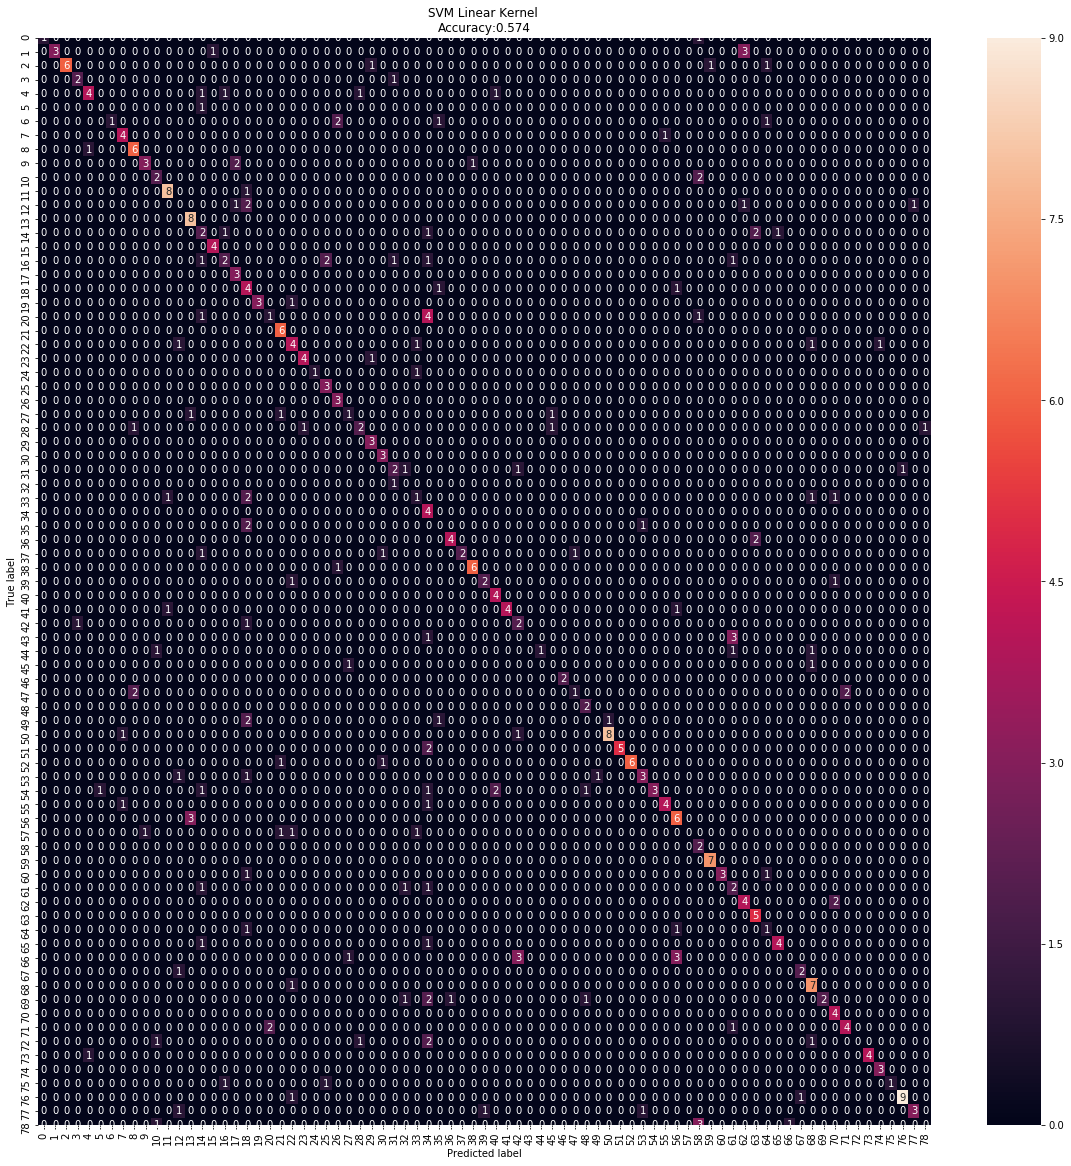

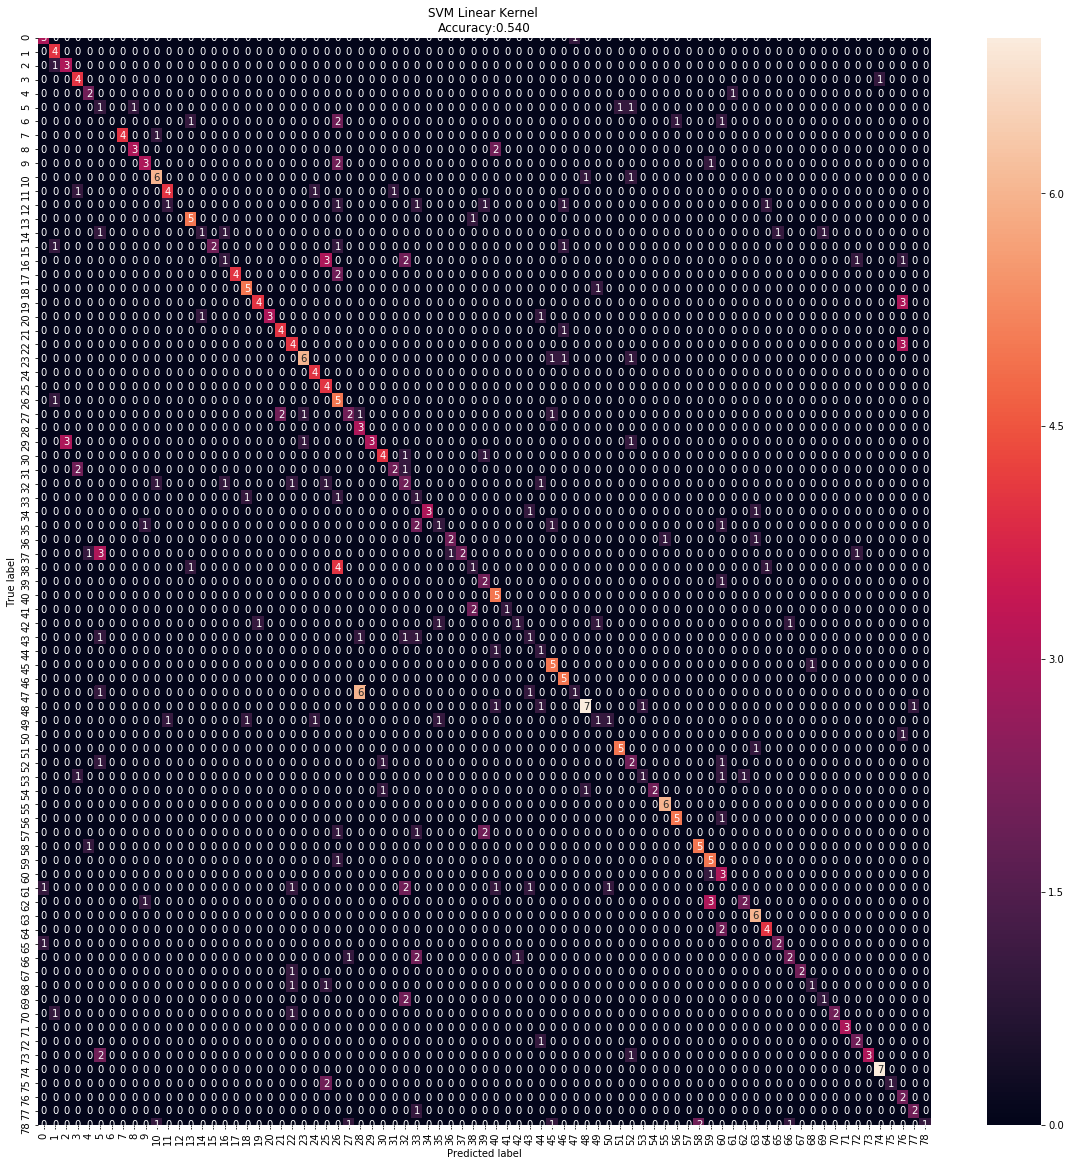

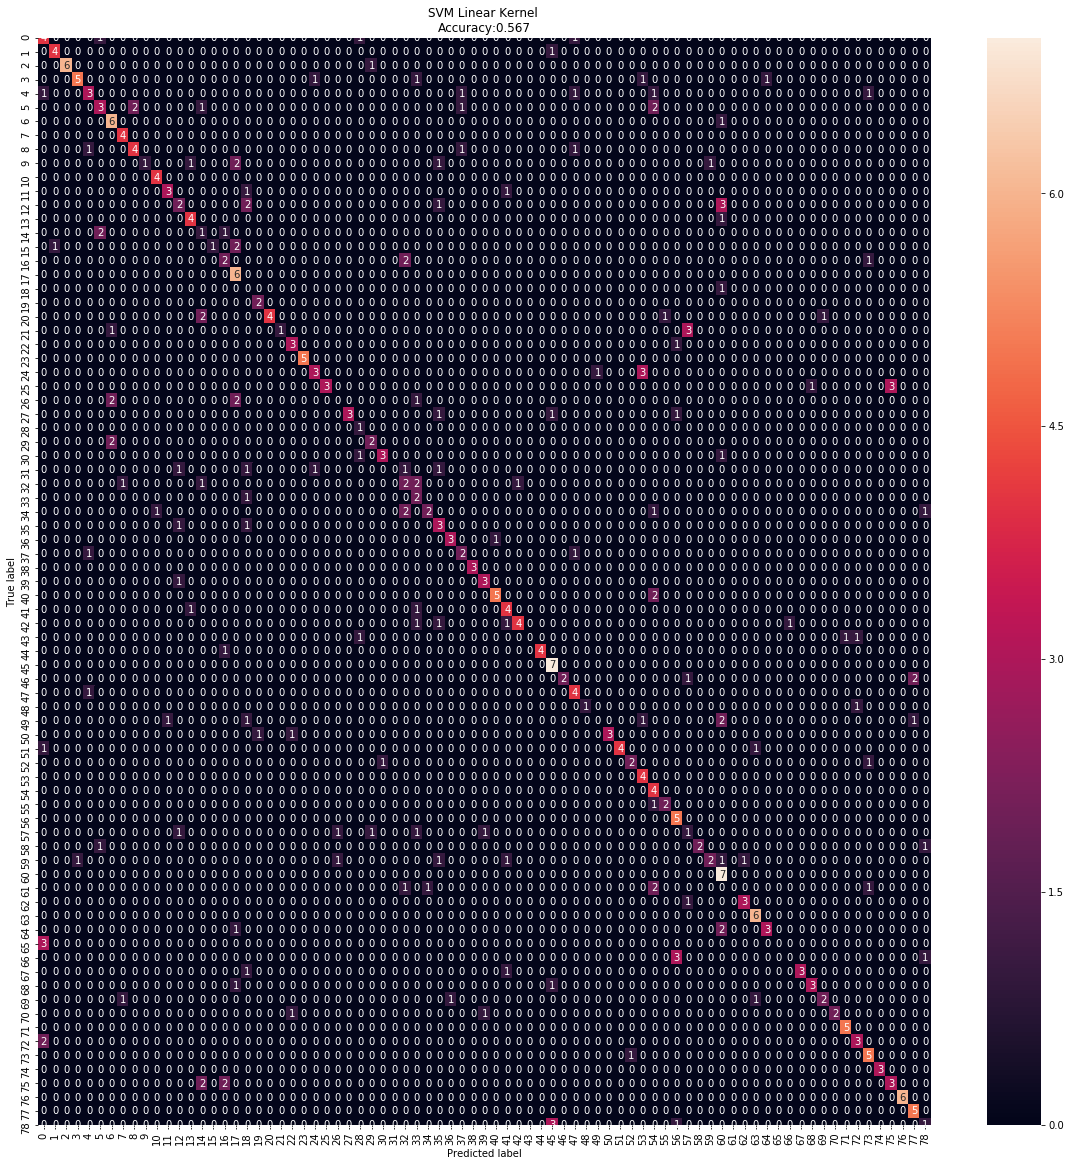

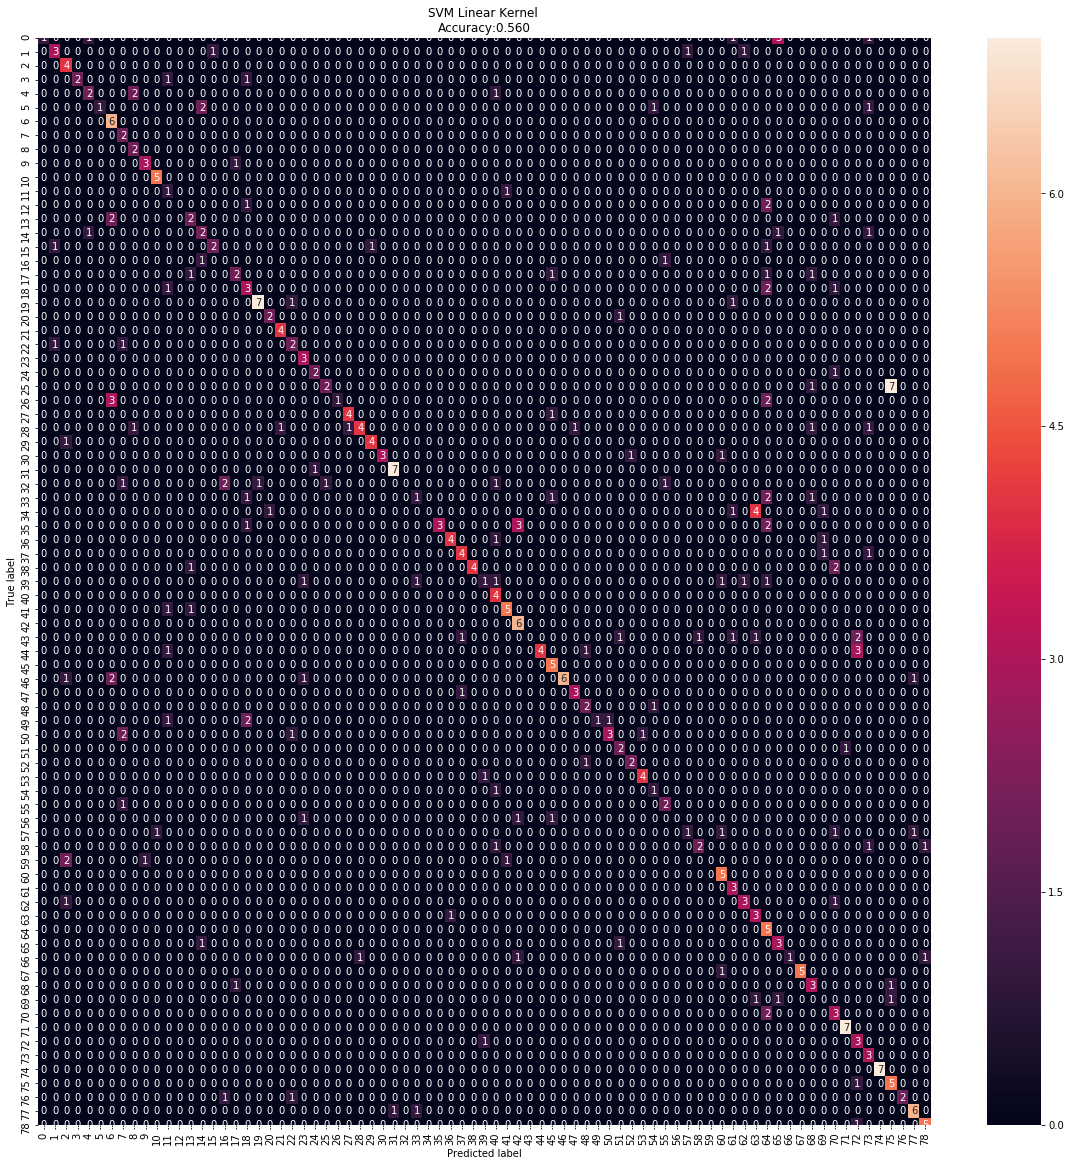

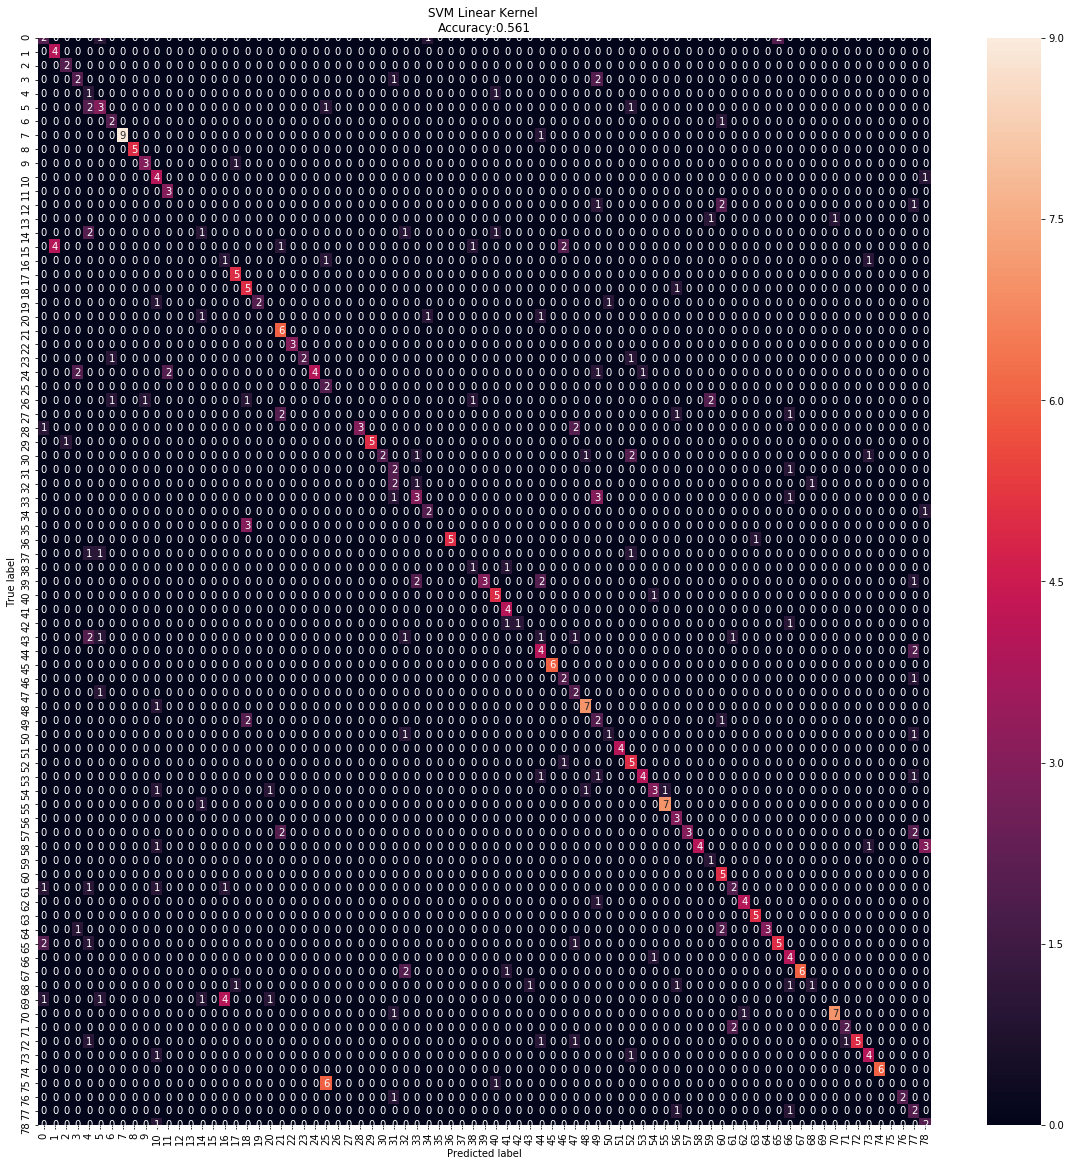

In [63]:
iKFold =1
for conv in confusionMatrix_dwt:
    print("this is confusion Matrix for :{} KFold:".format(iKFold))
    drawConfusionMatrix(conv[0] , conv[1])
    print()
    iKFold+=1

# 2- DWT & PCA

In [ ]:
cumulative_explained_variance(X_dwt)

In [ ]:
X_projected_dwt=get_pca_projection(32,X_dwt)

In [ ]:
scores_dwtPca, history_dwtPca , confusionMatrix_dwtPca , BPNN_dwtPca = fitingModelCnn(X_projected_dwt , Y_dwt , PCA = True)

### evaluate model

In [ ]:
iKFold =1
for ev in scores_dwtPca:
    print("this is score for :{} KFold:".format(iKFold))
    print(ev)
    print()
    iKFold+=1

### draw all history one by one

In [ ]:
iKFold =1
for hist in history_dwtPca:
    print("this is history for :{} KFold:".format(iKFold))
    drawHistory(hist)
    print()
    iKFold =iKFold + 1

### draw all history accuracy

In [ ]:
drawALLHistoryAccuracy(history_dwtPca)

### draw all history accuracy

### draw all history loss

In [ ]:
drawALLHistoryLoss(history_dwtPca)

### draw confusion matrix 

In [ ]:
iKFold =1
for conv in confusionMatrix_dwtPca:
    print("this is confusion Matrix for :{} KFold:".format(iKFold))
    drawConfusionMatrix(conv[0] , conv[1])
    print()
    iKFold+=1

# 3- DWT & MFCC

In [55]:
# if we need augment just change augmentData=True

X_DwtMfcc , Y_DwtMfcc = intialVariabels(5 , augmentData=False,dwtMfcc=True )

All Data leangth is : 2054

categorical leangth is : 2054


In [56]:
X_DwtMfcc.shape

(2054, 128)

In [20]:
scores_DwtMfcc, history_DwtMfcc , confusionMatrix_DwtMfcc , BPNN_DwtMfcc = fitingModelCnn(X_DwtMfcc , Y_DwtMfcc)

Train Data leangth for KFold :1 : is 1643
Test Data leangth for KFold :1 : is 411


Epoch 1/7
33/33 [==============================] - ETA: 16s - loss: 4.4943 - accuracy: 0.0000e+0 - ETA: 3s - loss: 5.7377 - accuracy: 0.0100    - ETA: 3s - loss: 5.8087 - accuracy: 0.00 - ETA: 3s - loss: 5.7035 - accuracy: 0.01 - ETA: 3s - loss: 5.5089 - accuracy: 0.00 - ETA: 3s - loss: 5.4332 - accuracy: 0.01 - ETA: 2s - loss: 5.3639 - accuracy: 0.01 - ETA: 2s - loss: 5.3198 - accuracy: 0.02 - ETA: 2s - loss: 5.2672 - accuracy: 0.02 - ETA: 2s - loss: 5.2048 - accuracy: 0.02 - ETA: 2s - loss: 5.1286 - accuracy: 0.02 - ETA: 2s - loss: 5.0493 - accuracy: 0.03 - ETA: 2s - loss: 4.9863 - accuracy: 0.03 - ETA: 2s - loss: 4.9231 - accuracy: 0.04 - ETA: 1s - loss: 4.8674 - accuracy: 0.04 - ETA: 1s - loss: 4.8090 - accuracy: 0.04 - ETA: 1s - loss: 4.7537 - accuracy: 0.04 - ETA: 1s - loss: 4.6800 - accuracy: 0.05 - ETA: 1s - loss: 4.6449 - accuracy: 0.05 - ETA: 1s - loss: 4.6001 - accuracy: 0.06 - ETA: 1s - loss

### evaluate model

In [21]:
iKFold =1
for ev in scores_DwtMfcc:
    print("this is score for :{} KFold:".format(iKFold))
    print(ev)
    print()
    iKFold+=1

this is score for :1 KFold:
0.9683698415756226

this is score for :2 KFold:
0.970802903175354

this is score for :3 KFold:
0.970802903175354

this is score for :4 KFold:
0.9732360243797302

this is score for :5 KFold:
0.9756097793579102



### draw all history one by one

this is history for :1 KFold:


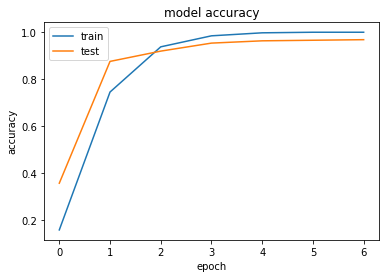

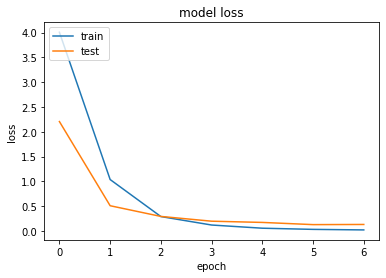


this is history for :2 KFold:


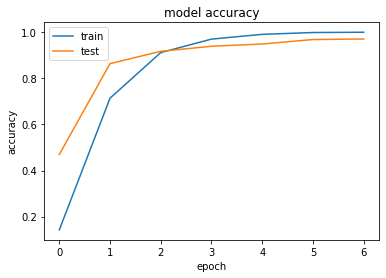

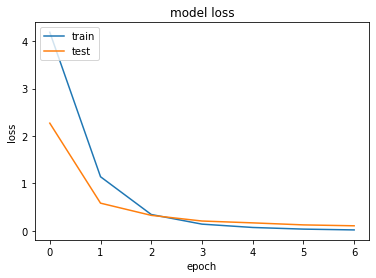


this is history for :3 KFold:


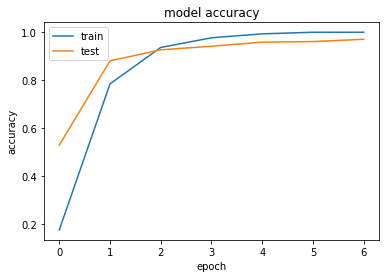

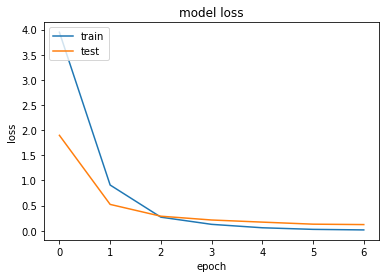


this is history for :4 KFold:


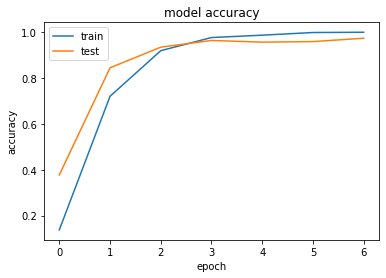

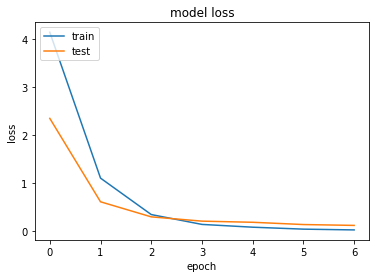


this is history for :5 KFold:


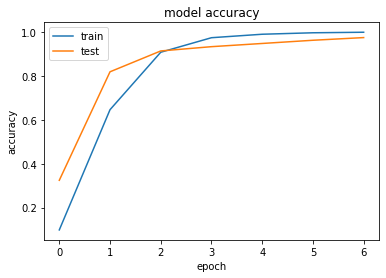

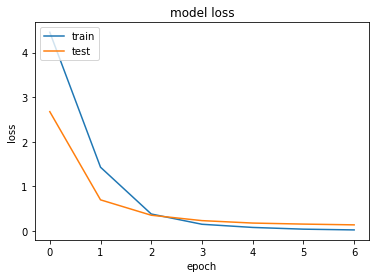

In [22]:
iKFold =1
for hist in history_DwtMfcc:
    print("this is history for :{} KFold:".format(iKFold))
    drawHistory(hist)
    print()
    iKFold =iKFold + 1

### draw all history accuracy

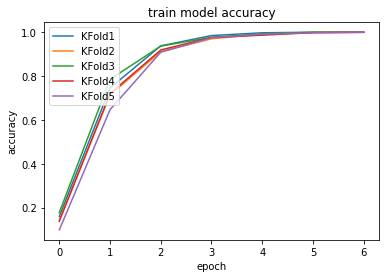

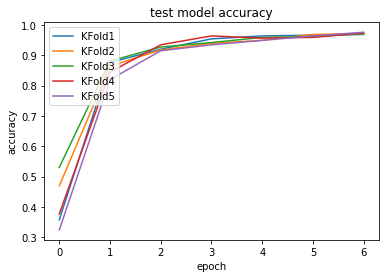

In [23]:
drawALLHistoryAccuracy(history_DwtMfcc)

### draw all history accuracy

### draw all history loss

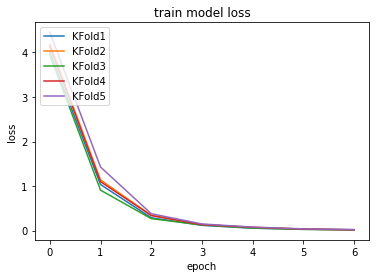

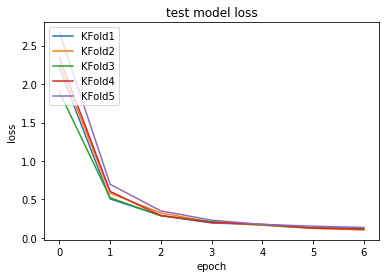

In [24]:
drawALLHistoryLoss(history_DwtMfcc)

### draw confusion matrix 

this is confusion Matrix for :1 KFold:

this is confusion Matrix for :2 KFold:

this is confusion Matrix for :3 KFold:

this is confusion Matrix for :4 KFold:

this is confusion Matrix for :5 KFold:



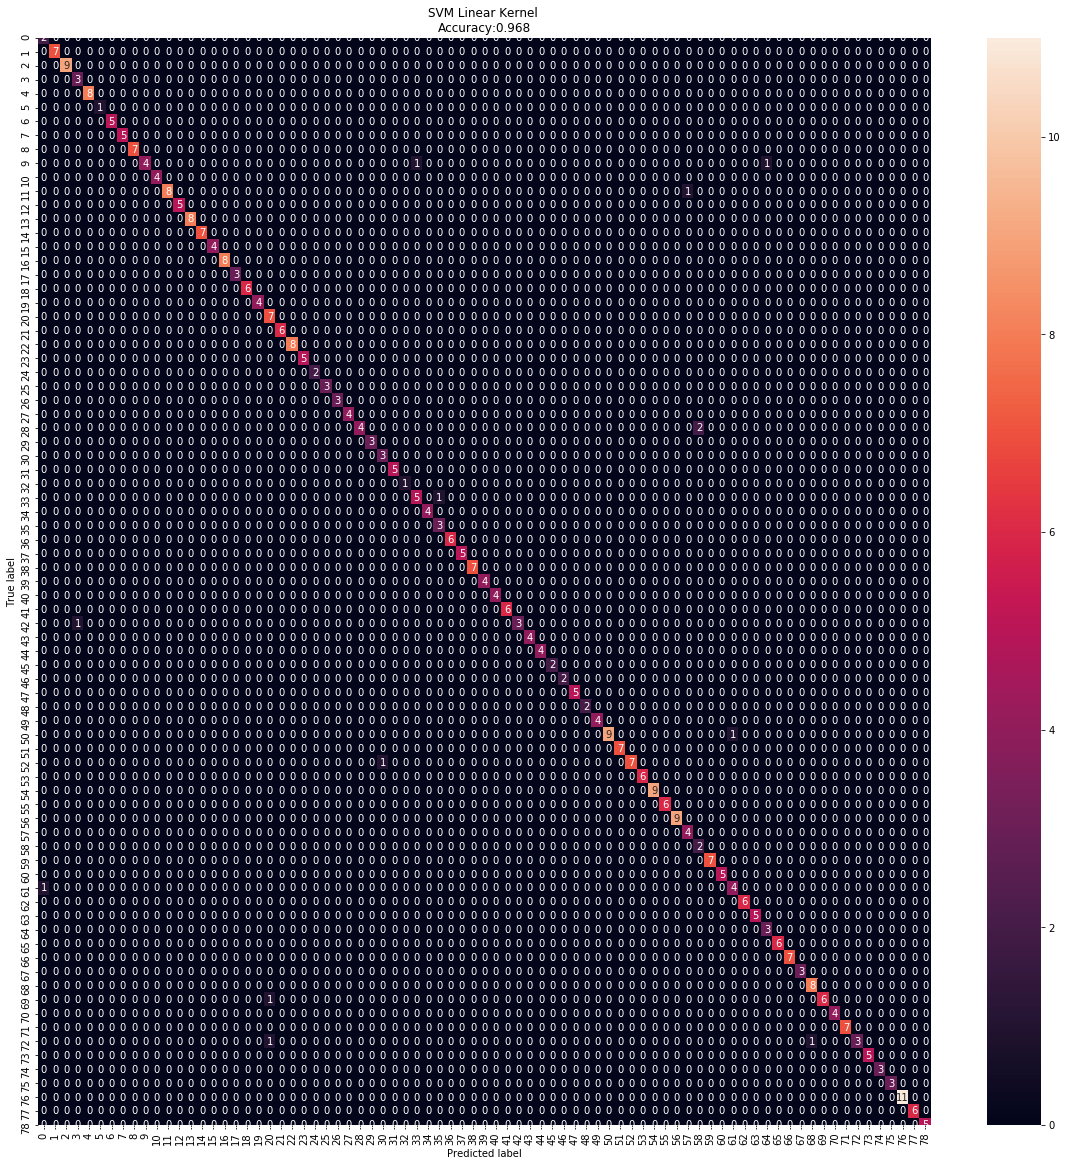

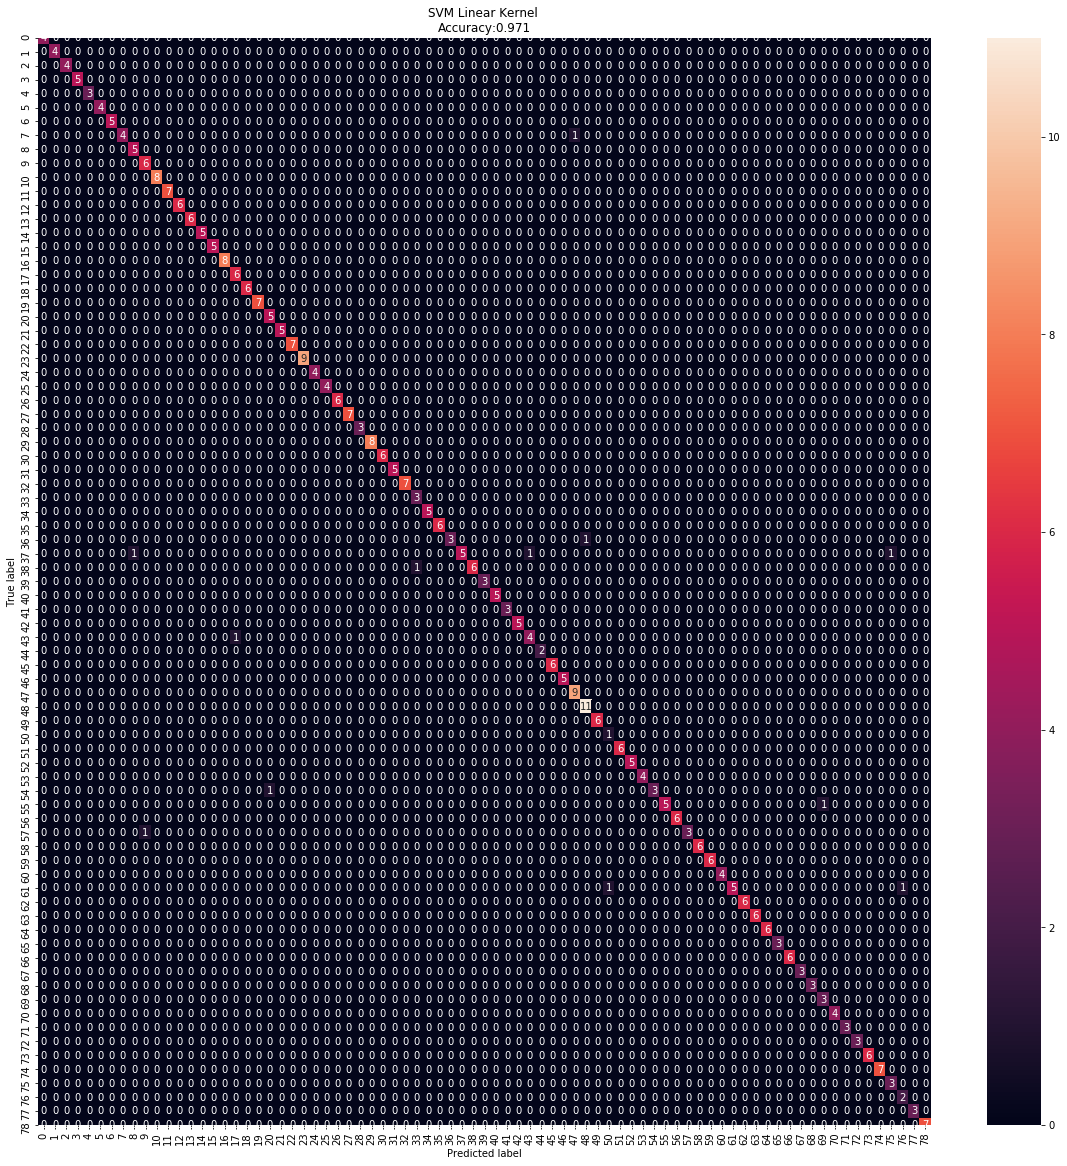

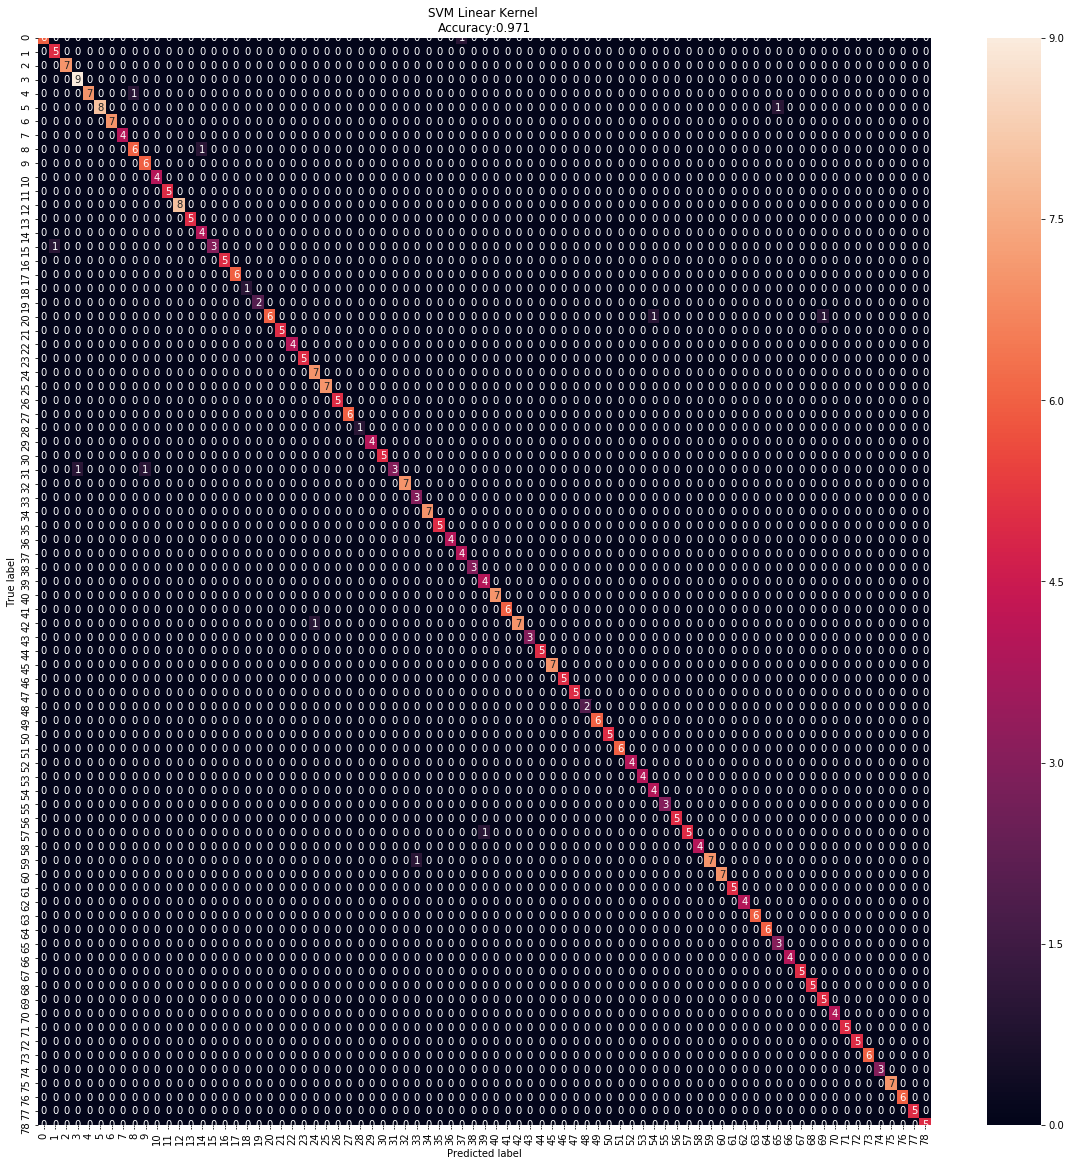

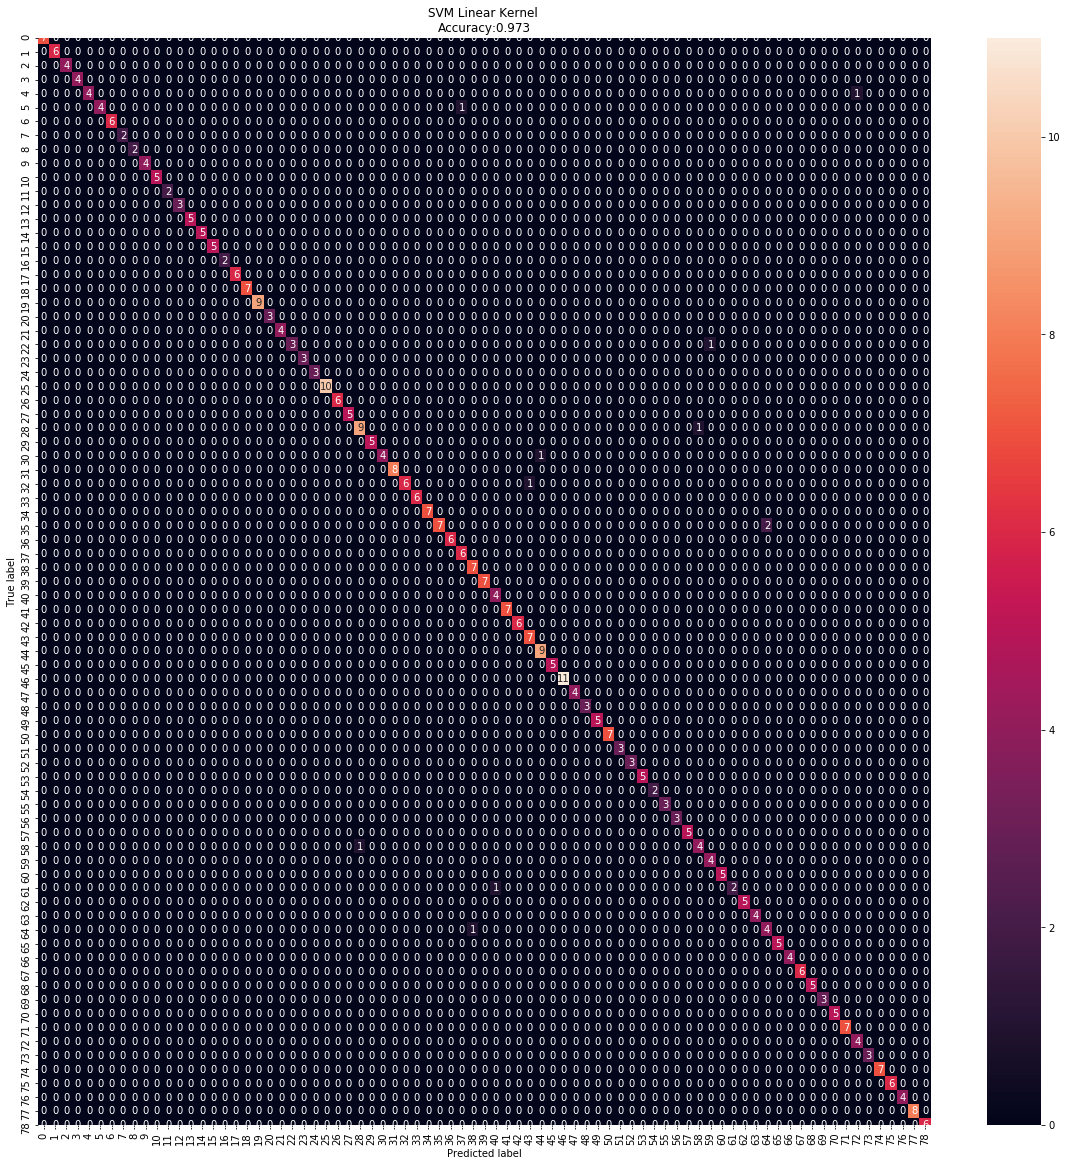

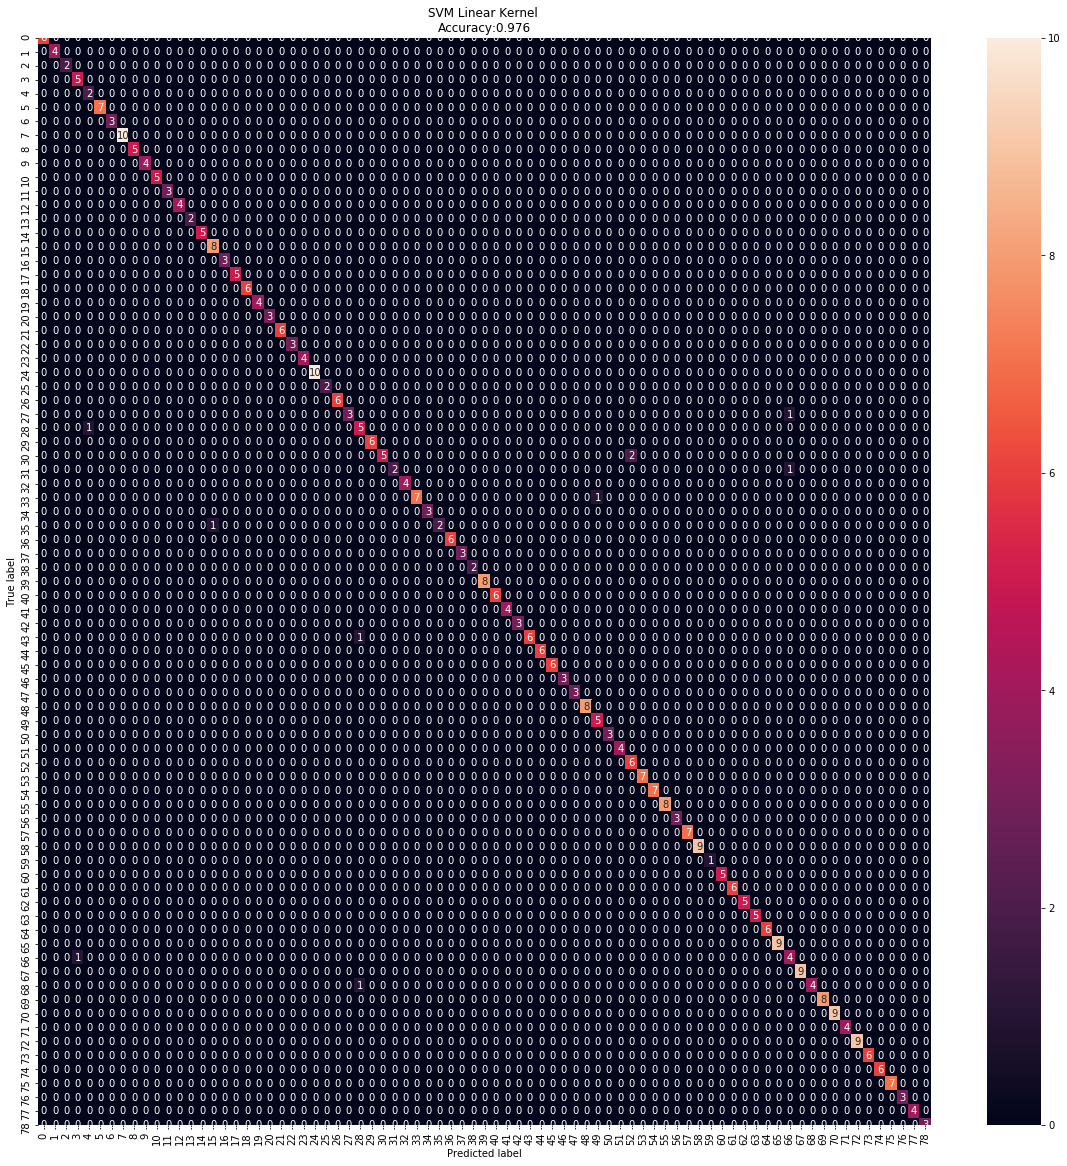

In [25]:
iKFold =1
for conv in confusionMatrix_DwtMfcc:
    print("this is confusion Matrix for :{} KFold:".format(iKFold))
    drawConfusionMatrix(conv[0] , conv[1])
    print()
    iKFold+=1

# 4- MFCC & PCA

In [26]:
# if we need augment just change augmentData=True

X_Mfcc , Y_Mfcc = intialVariabels(5 , augmentData=False ,mfcc = True)

All Data leangth is : 2054

categorical leangth is : 2054


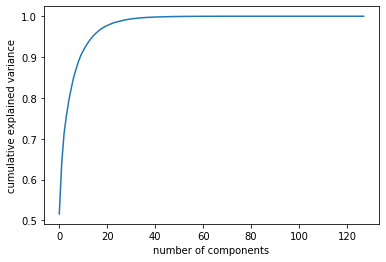

In [27]:
cumulative_explained_variance(X_Mfcc)

In [28]:
X_projected_mfccPca=get_pca_projection(32,X_Mfcc)

original data shape : 
(2054, 128)
projected data shape : 
(2054, 32)


In [29]:
scores_mfccPca, history_mfccPca , confusionMatrix_mfccPca , BPNN_mfccPca = fitingModelCnn(X_projected_mfccPca , Y_Mfcc,PCA=True)

Train Data leangth for KFold :1 : is 1643
Test Data leangth for KFold :1 : is 411


Epoch 1/7
33/33 [==============================] - ETA: 13s - loss: 4.4914 - accuracy: 0.0000e+0 - ETA: 1s - loss: 4.4992 - accuracy: 0.0100    - ETA: 1s - loss: 4.5451 - accuracy: 0.02 - ETA: 1s - loss: 4.4967 - accuracy: 0.03 - ETA: 1s - loss: 4.4451 - accuracy: 0.04 - ETA: 1s - loss: 4.3953 - accuracy: 0.04 - ETA: 1s - loss: 4.3724 - accuracy: 0.05 - ETA: 1s - loss: 4.3254 - accuracy: 0.06 - ETA: 1s - loss: 4.2945 - accuracy: 0.06 - ETA: 1s - loss: 4.2713 - accuracy: 0.06 - ETA: 1s - loss: 4.2227 - accuracy: 0.07 - ETA: 1s - loss: 4.1809 - accuracy: 0.08 - ETA: 1s - loss: 4.1234 - accuracy: 0.09 - ETA: 1s - loss: 4.0673 - accuracy: 0.10 - ETA: 1s - loss: 4.0162 - accuracy: 0.10 - ETA: 1s - loss: 3.9633 - accuracy: 0.12 - ETA: 0s - loss: 3.8947 - accuracy: 0.14 - ETA: 0s - loss: 3.8516 - accuracy: 0.14 - ETA: 0s - loss: 3.8061 - accuracy: 0.15 - ETA: 0s - loss: 3.7340 - accuracy: 0.17 - ETA: 0s - loss

### evaluate model

In [30]:
iKFold =1
for ev in scores_mfccPca:
    print("this is score for :{} KFold:".format(iKFold))
    print(ev)
    print()
    iKFold+=1

this is score for :1 KFold:
0.970802903175354

this is score for :2 KFold:
0.9610705375671387

this is score for :3 KFold:
0.9781022071838379

this is score for :4 KFold:
0.9756690859794617

this is score for :5 KFold:
0.9634146094322205



### draw all history one by one

this is history for :1 KFold:


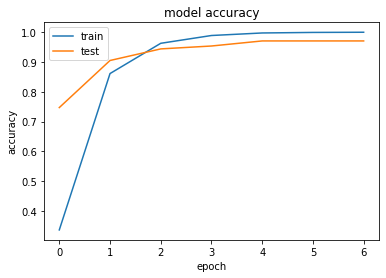

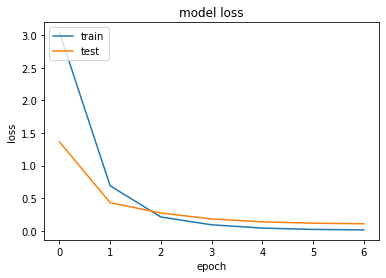


this is history for :2 KFold:


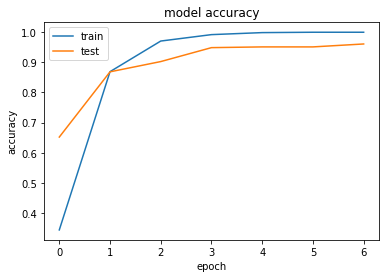

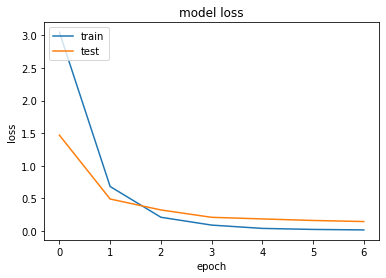


this is history for :3 KFold:


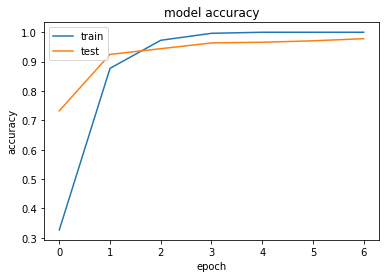

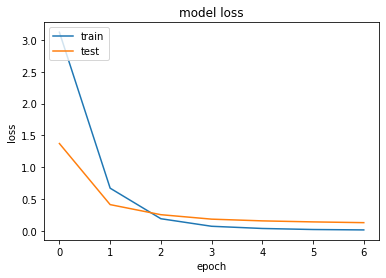


this is history for :4 KFold:


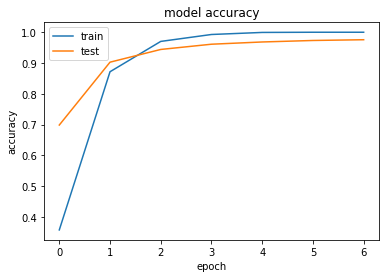

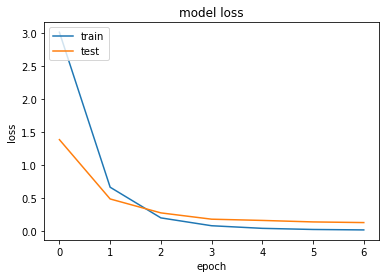


this is history for :5 KFold:


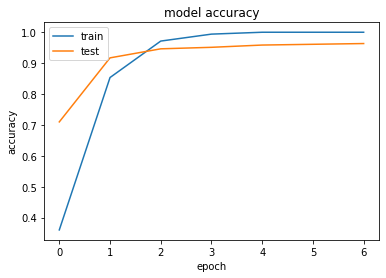

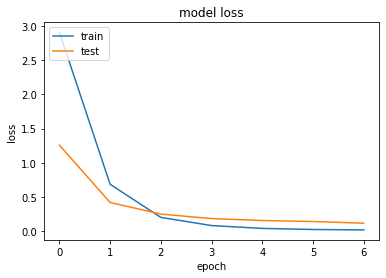

In [31]:
iKFold =1
for hist in history_mfccPca:
    print("this is history for :{} KFold:".format(iKFold))
    drawHistory(hist)
    print()
    iKFold =iKFold + 1

### draw all history accuracy

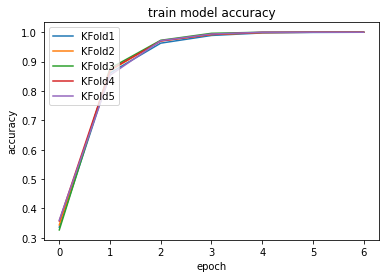

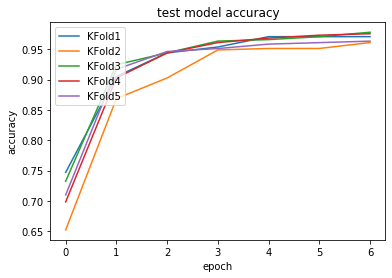

In [32]:
drawALLHistoryAccuracy(history_mfccPca)

### draw all history accuracy

### draw all history loss

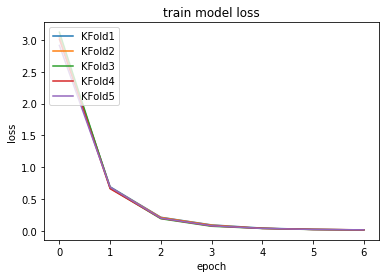

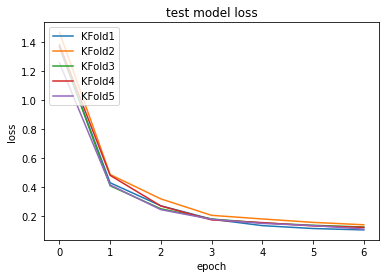

In [33]:
drawALLHistoryLoss(history_mfccPca)

### draw confusion matrix 

this is confusion Matrix for :1 KFold:

this is confusion Matrix for :2 KFold:

this is confusion Matrix for :3 KFold:

this is confusion Matrix for :4 KFold:

this is confusion Matrix for :5 KFold:



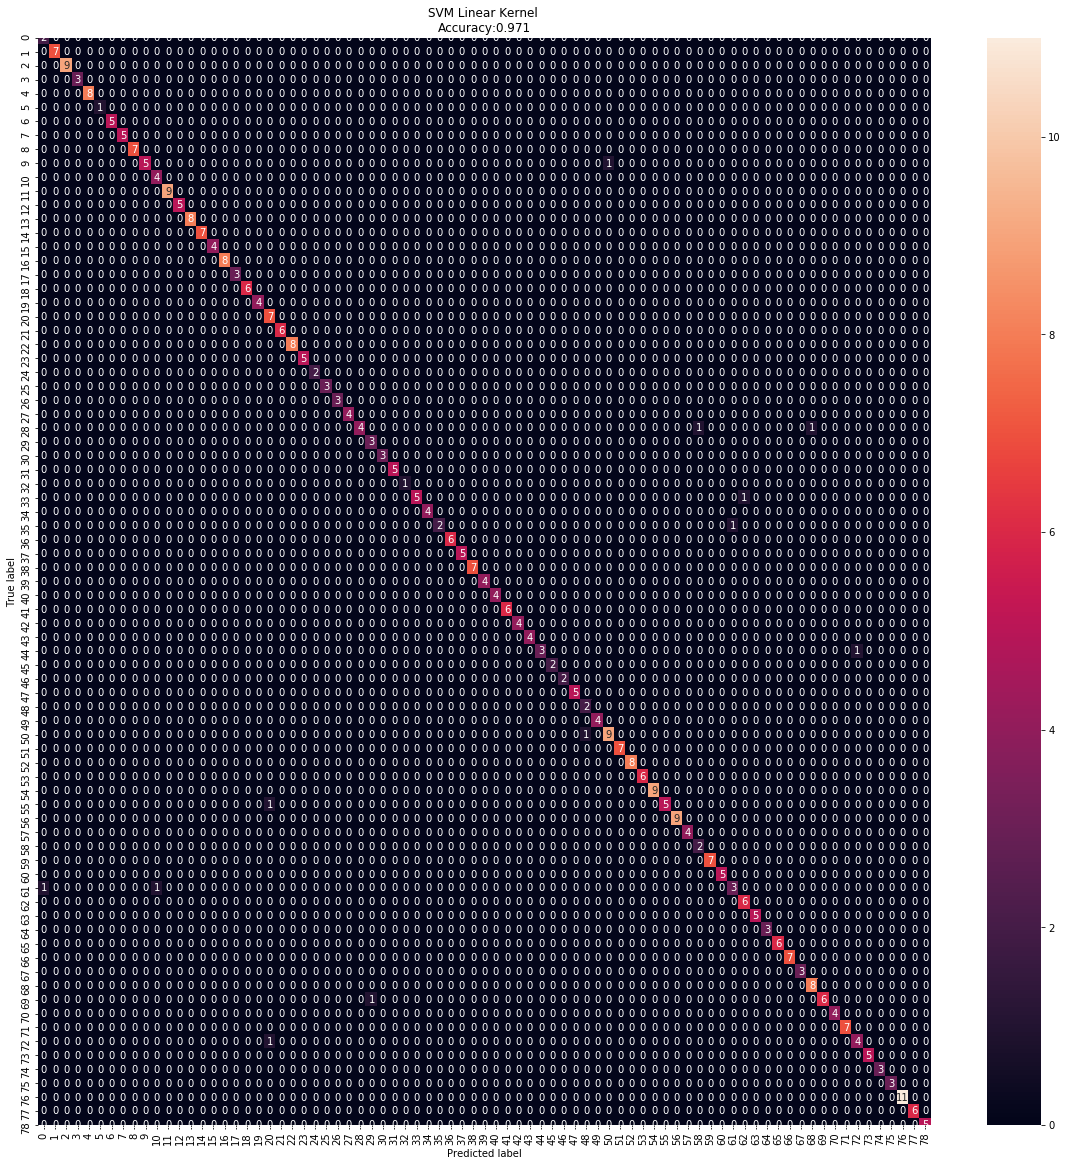

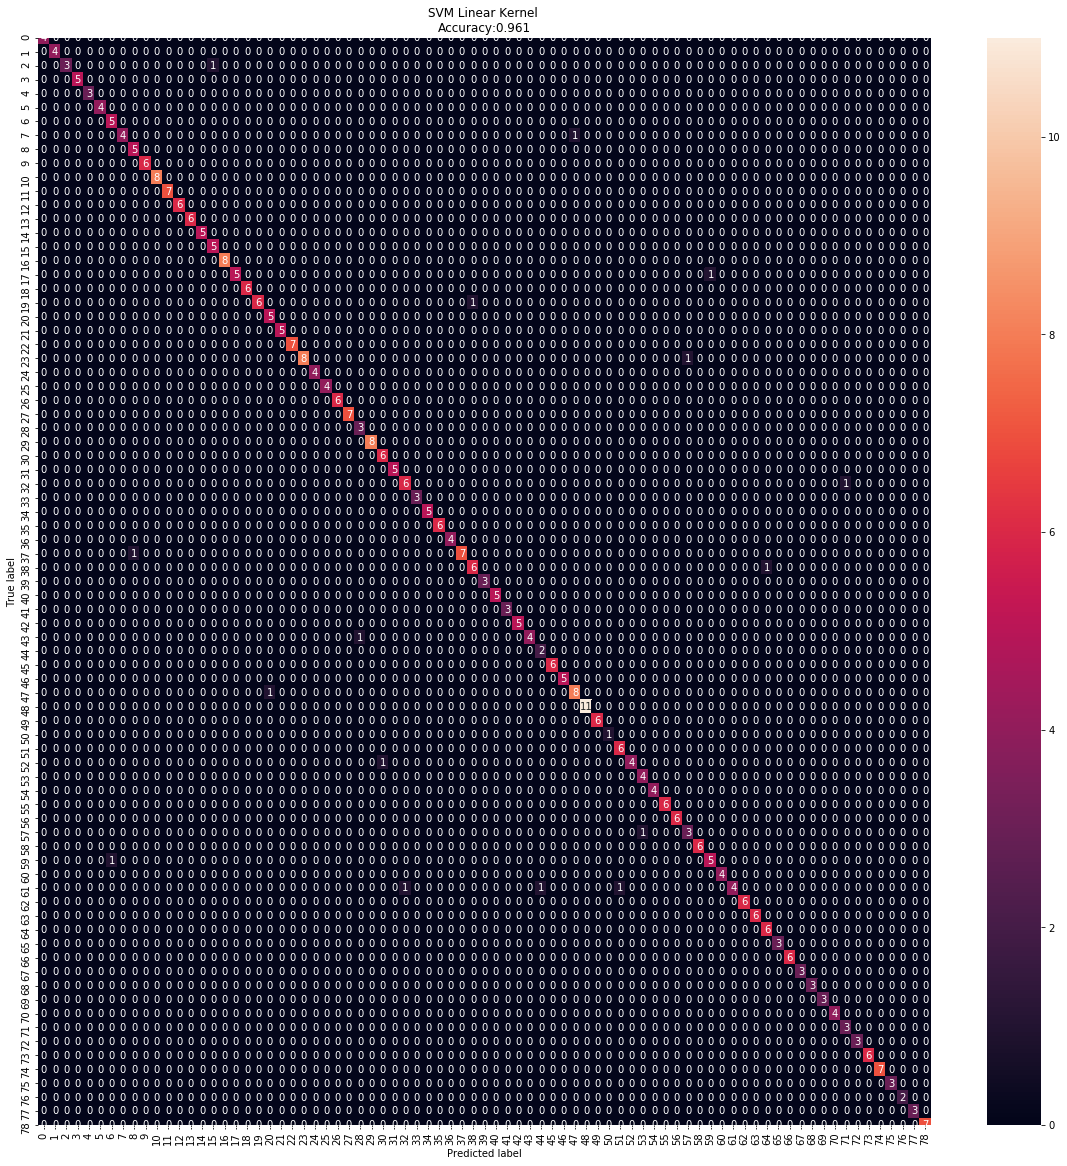

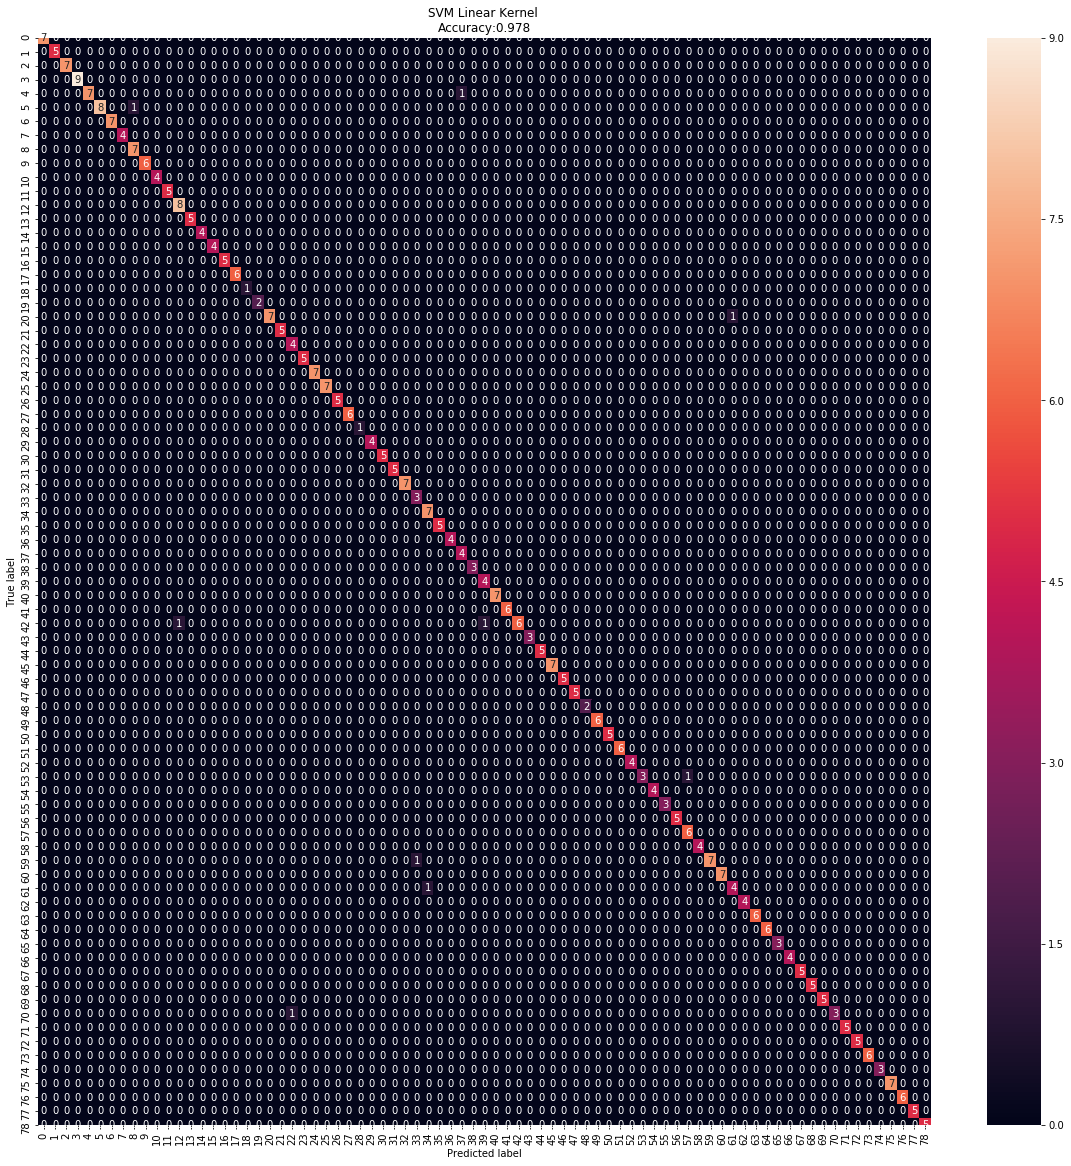

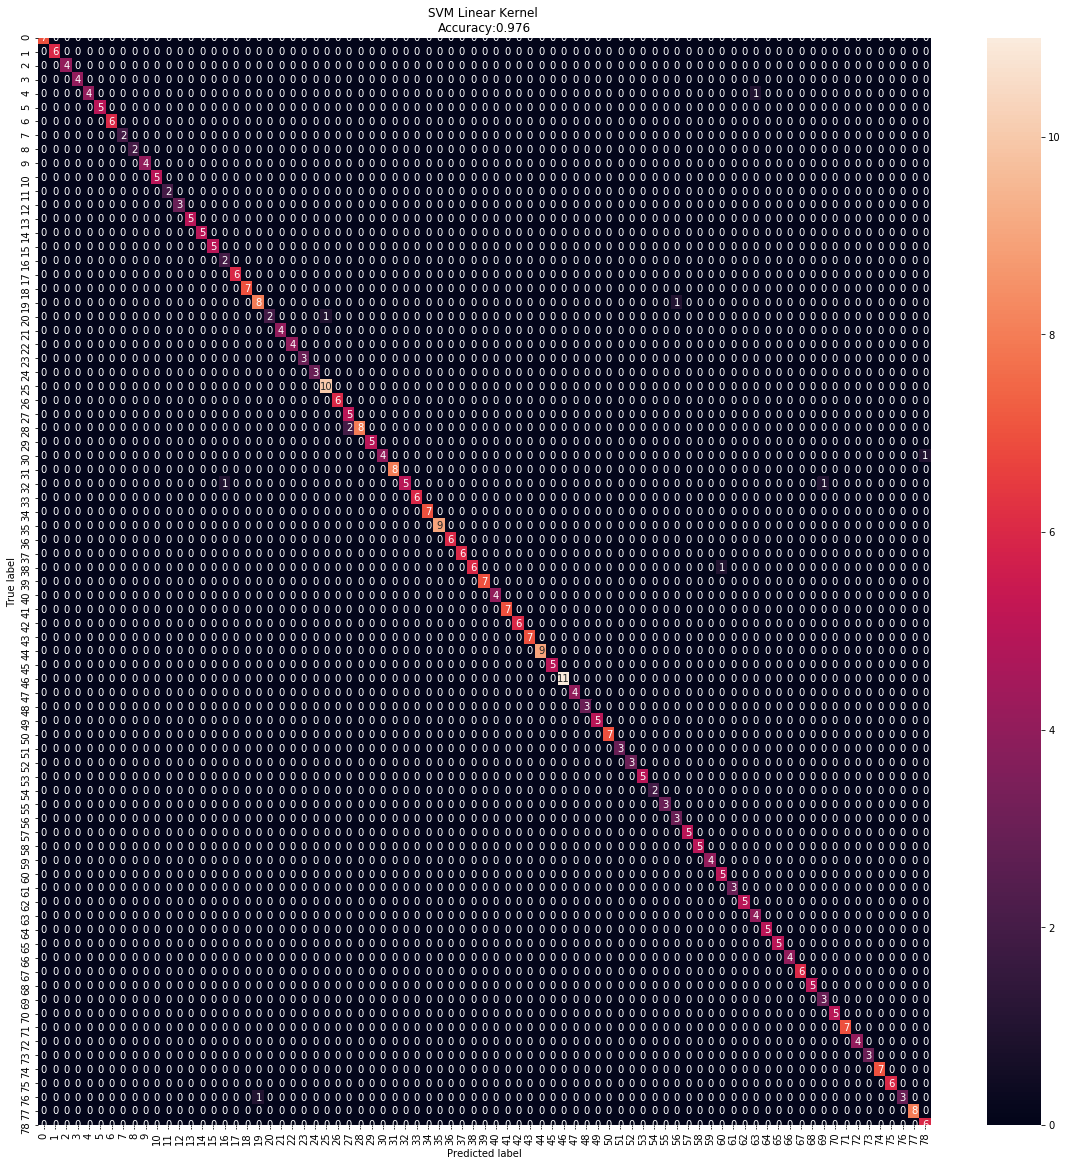

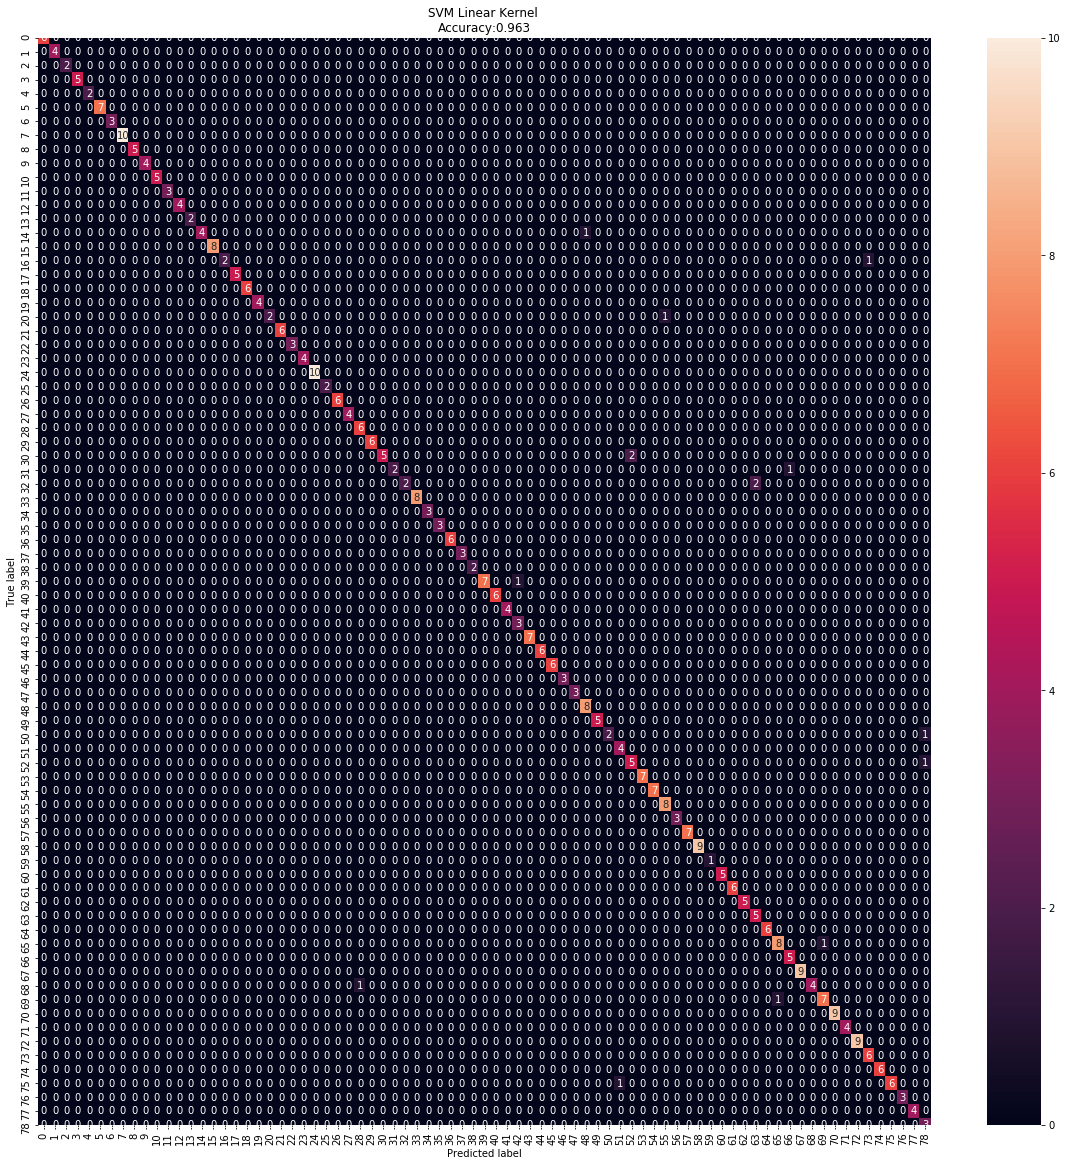

In [34]:
iKFold =1
for conv in confusionMatrix_mfccPca:
    print("this is confusion Matrix for :{} KFold:".format(iKFold))
    drawConfusionMatrix(conv[0] , conv[1])
    print()
    iKFold+=1

# Save Accuracy

### save best DWT accuracy

In [ ]:
saveAccuracy(scores_Dwt , history_Dwt , 'five_level2_DWT.csv' , True)

### save best DWT& PCA accuracy

In [43]:
saveAccuracy(scores_dwtPca , history_dwtPca , 'five_level2_PCA&DWT.csv' , True)

NameError: name 'scores_dwtPca' is not defined

### save best DWT& MFCC accuracy

In [55]:
saveAccuracy(scores_DwtMfcc , history_DwtMfcc , 'five_level2_DWT&MFCC.csv' , True)

### save best MFCC& PCA accuracy

In [56]:
saveAccuracy(scores_mfccPca , history_mfccPca , 'five_level2_PCA&MFCC.csv' , True)

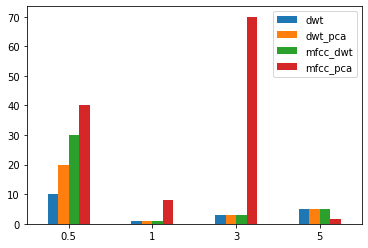

In [62]:
dwt = [10, 1, 3, 5]
dwt_pca = [20, 1, 3, 5]
mfcc_dwt = [30, 1, 3, 5]
mfcc_pca = [40, 8, 70, 1.5]
index = ['0.5', '1', '3',
         '5']
df = pd.DataFrame({'dwt': dwt,
                   'dwt_pca': dwt_pca,
                   'mfcc_dwt': mfcc_dwt,
                   'mfcc_pca': mfcc_pca}, index=index)
ax = df.plot.bar(rot=0)